# How can you maximize your salary as a Data Analyst? 
- Which skills are most strongly correlated with higher pay?
- What type of job better to search for - Remote/In-Office?
- Do you need special degree to get bigger salary?
- When better to search for a job to get bigger salary.

### For now correlations calculated globally - for all countrieas and job titles - need to review

In [11]:
import pandas as pd
#import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import ast


df = pd.read_csv('/Users/kolesnikevgenia/Documents/Python_Projects/Job_Skills/Raw_Data/df_Final.csv')

### Remove Salary Outliers

In [12]:
df_eu_ds = df[
    (df['region_group'] == 'EU') &
    (df['job_title_short'] == 'Data Analyst')
]

#Calculate global IQR
Q1_global = df_eu_ds['salary_month_avg_eur'].quantile(0.25)
Q3_global = df_eu_ds['salary_month_avg_eur'].quantile(0.75)
IQR_global = Q3_global - Q1_global
lower_bound_global = Q1_global - 1.5 * IQR_global
upper_bound_global = Q3_global + 1.5 * IQR_global

#Build list to collect filtered results
filtered_groups = []

#Iterate over groups manually
for (country, title), group in df_eu_ds.groupby(['job_country', 'job_title_short']):
    if len(group) >= 5:
        Q1 = group['salary_month_avg_eur'].quantile(0.25)
        Q3 = group['salary_month_avg_eur'].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
    else:
        lower = lower_bound_global
        upper = upper_bound_global

    filtered = group[
        (group['salary_month_avg_eur'] >= lower) &
        (group['salary_month_avg_eur'] <= upper)
    ]
    filtered_groups.append(filtered)

# Combine all groups back
df_filtered = pd.concat(filtered_groups, ignore_index=True)

print(f"Original dataset size: {len(df_eu_ds)}")
print(f"Filtered dataset size: {len(df_filtered)}")

Original dataset size: 388
Filtered dataset size: 378


In [13]:
df_technology = df_filtered['job_type_skills'].copy()

df_technology = df_technology.drop_duplicates()
df_technology = df_technology.dropna()

#combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value
    
#remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_dropna = df_filtered.dropna(subset=['job_skills']).copy()
df_dropna['job_skills'] = df_dropna['job_skills'].apply(ast.literal_eval)
df_exploded = df_dropna.explode('job_skills')

df_plot = df_exploded.merge(df_technology, left_on='job_skills', right_on='skills').copy()

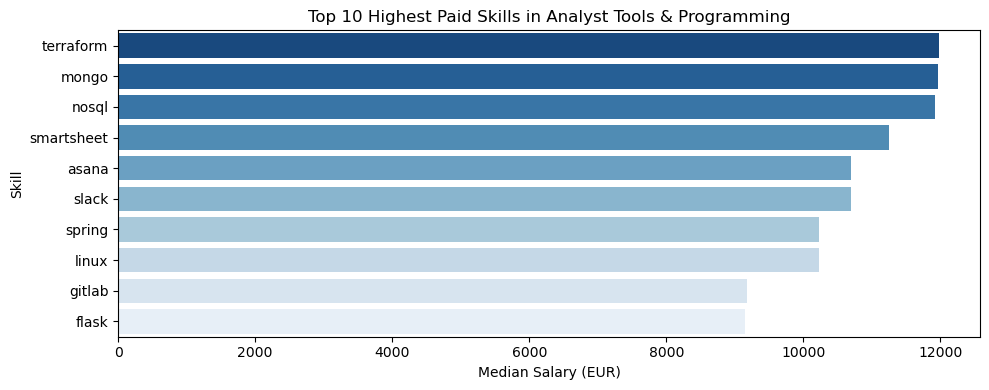

In [14]:
top_skills_combined = (
    df_plot.groupby('job_skills')['salary_month_avg_eur']
    .median()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Rename columns for clarity
top_skills_combined.columns = ['skill', 'median_salary_eur']

# Optional: plot for clearer visualization
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_skills_combined,
    y='skill',
    x='median_salary_eur',
    hue='skill',
    dodge=False,
    legend=False,
    palette='Blues_r'
)
plt.title('Top 10 Highest Paid Skills in Analyst Tools & Programming')
plt.xlabel('Median Salary (EUR)')
plt.ylabel('Skill')
plt.tight_layout()
plt.show()

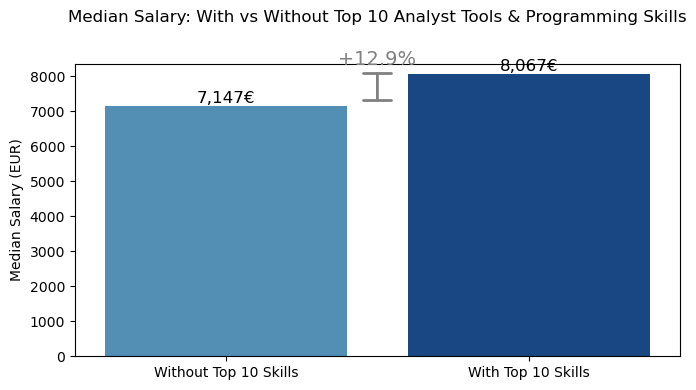

In [17]:
# Define df_analyst_prog with the two tech types
df_analyst_prog = df_plot[df_plot['technology'].isin(['analyst_tools', 'programming'])].copy()

# Drop rows with missing salary or skills
df_analyst_prog = df_analyst_prog.dropna(subset=['salary_month_avg_eur', 'job_skills'])

# Calculate top-10 highest median-paying skills across both technologies
top_skills_combined = (
    df_analyst_prog.groupby('job_skills')['salary_month_avg_eur']
    .median()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

# Create the set needed
top_skills_set = set(top_skills_combined)

# Label whether each skill is in top 10 combined skills
df_plot['has_top_skill'] = df_plot['job_skills'].apply(lambda s: s in top_skills_set)

# Drop rows with missing salary
df_plot_valid = df_plot.dropna(subset=['salary_month_avg_eur'])

# Compute median salary by skill group
median_salary_comparison = (
    df_plot_valid.groupby('has_top_skill')['salary_month_avg_eur']
    .median()
    .reset_index()
)

# Add group labels
median_salary_comparison['group'] = median_salary_comparison['has_top_skill'].map({
    True: 'With Top 10 Skills',
    False: 'Without Top 10 Skills'
})

# Sort so "Without" comes first
median_salary_comparison = median_salary_comparison.sort_values(by='has_top_skill', ascending=True)

# Get values for arrow
top_salary = median_salary_comparison.loc[median_salary_comparison['has_top_skill'], 'salary_month_avg_eur'].iloc[0]
other_salary = median_salary_comparison.loc[~median_salary_comparison['has_top_skill'], 'salary_month_avg_eur'].iloc[0]
pct_diff = (top_salary - other_salary) / other_salary * 100

# Plot
plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data=median_salary_comparison,
    x='group',
    y='salary_month_avg_eur',
    hue='group',
    palette=['#4292c6', '#084594'],
    dodge=False,
    legend=False
)

# Add labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 100,
        f"{height:,.0f}€",
        ha='center',
        fontsize=12
    )

# Arrow and % annotation
x_pos = 0.5
y_start = other_salary + 100
y_end = top_salary + 100

ax.annotate(
    '',
    xy=(x_pos, y_end),
    xytext=(x_pos, y_start),
    arrowprops=dict(arrowstyle='|-|', color='grey', lw=2)
)

ax.text(
    x_pos,
    y_end + 50,
    f'+{pct_diff:.1f}%',
    ha='center',
    va='bottom',
    fontsize=14,
    color='grey'
)

plt.title('Median Salary: With vs Without Top 10 Analyst Tools & Programming Skills', pad=30)
plt.ylabel('Median Salary (EUR)')
plt.xlabel('')
plt.ylim(0, y_end + 200)
plt.tight_layout()
plt.show()

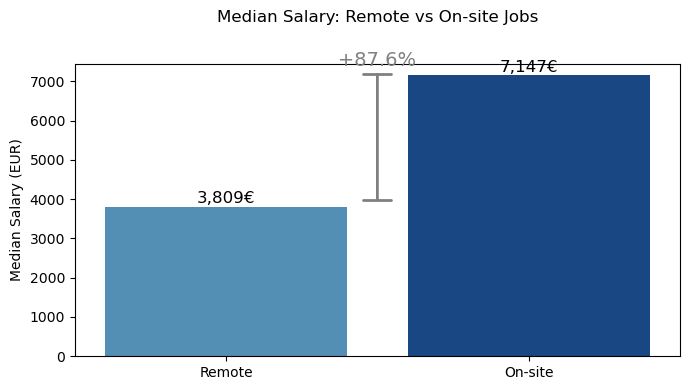

In [19]:
column_name = 'job_work_from_home'  

# Drop rows with missing salary or the column
df_flagged = df_plot.dropna(subset=['salary_month_avg_eur', column_name])

# Group and calculate median salary
salary_comparison = (
    df_flagged.groupby(column_name)['salary_month_avg_eur']
    .median()
    .reset_index()
    .rename(columns={column_name: 'group_flag'})
)

# Map labels for plot
if column_name == 'job_work_from_home':
    group_labels = {True: 'Remote', False: 'On-site'}
elif column_name == 'job_no_degree_mention':
    group_labels = {True: 'No Degree Mentioned', False: 'Degree Mentioned'}

salary_comparison['group'] = salary_comparison['group_flag'].map(group_labels)

# Sort: put lower-paying group first
salary_comparison = salary_comparison.sort_values(by='salary_month_avg_eur')

# Calculate % difference
top_salary = salary_comparison['salary_month_avg_eur'].max()
other_salary = salary_comparison['salary_month_avg_eur'].min()
pct_diff = (top_salary - other_salary) / other_salary * 100

# Plot
plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data=salary_comparison,
    x='group',
    y='salary_month_avg_eur',
    hue='group',
    palette=['#4292c6', '#084594'],  # lighter blue, then darker blue
    dodge=False,
    legend=False
)

# Add salary labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 100,
        f"{height:,.0f}€",
        ha='center',
        fontsize=12
    )

# Vertical arrow from lower bar to top bar
x_pos = 0.5
y_start = other_salary + 100
y_end = top_salary + 100

ax.annotate(
    '',
    xy=(x_pos, y_end),
    xytext=(x_pos, y_start),
    arrowprops=dict(arrowstyle='|-|', color='grey', lw=2)
)

# Add % difference
ax.text(
    x_pos,
    y_end + 50,
    f'+{pct_diff:.1f}%',
    ha='center',
    va='bottom',
    fontsize=14,
    color='grey'
)

# Title and labels
title_map = {
    'job_work_from_home': 'Median Salary: Remote vs On-site Jobs',
    'job_no_degree_mention': 'Median Salary: With vs Without Degree Mention'
}
plt.title(title_map[column_name], pad=30)
plt.ylabel('Median Salary (EUR)')
plt.xlabel('')
plt.ylim(0, y_end + 200)
plt.tight_layout()
plt.show()

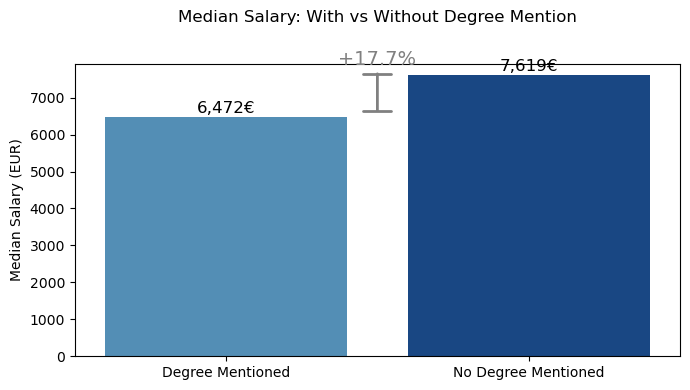

In [21]:
column_name = 'job_no_degree_mention'  

# Drop rows with missing salary or the column
df_flagged = df_plot.dropna(subset=['salary_month_avg_eur', column_name])

# Group and calculate median salary
salary_comparison = (
    df_flagged.groupby(column_name)['salary_month_avg_eur']
    .median()
    .reset_index()
    .rename(columns={column_name: 'group_flag'})
)

# Map labels for plot
if column_name == 'job_work_from_home':
    group_labels = {True: 'Remote', False: 'On-site'}
elif column_name == 'job_no_degree_mention':
    group_labels = {True: 'No Degree Mentioned', False: 'Degree Mentioned'}

salary_comparison['group'] = salary_comparison['group_flag'].map(group_labels)

# Sort: put lower-paying group first
salary_comparison = salary_comparison.sort_values(by='salary_month_avg_eur')

# Calculate % difference
top_salary = salary_comparison['salary_month_avg_eur'].max()
other_salary = salary_comparison['salary_month_avg_eur'].min()
pct_diff = (top_salary - other_salary) / other_salary * 100

# Plot
plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data=salary_comparison,
    x='group',
    y='salary_month_avg_eur',
    hue='group',
    palette=['#4292c6', '#084594'],  # lighter blue, then darker blue
    dodge=False,
    legend=False
)

# Add salary labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 100,
        f"{height:,.0f}€",
        ha='center',
        fontsize=12
    )

# Vertical arrow from lower bar to top bar
x_pos = 0.5
y_start = other_salary + 100
y_end = top_salary + 100

ax.annotate(
    '',
    xy=(x_pos, y_end),
    xytext=(x_pos, y_start),
    arrowprops=dict(arrowstyle='|-|', color='grey', lw=2)
)

# Add % difference
ax.text(
    x_pos,
    y_end + 50,
    f'+{pct_diff:.1f}%',
    ha='center',
    va='bottom',
    fontsize=14,
    color='grey'
)

# Title and labels
title_map = {
    'job_work_from_home': 'Median Salary: Remote vs On-site Jobs',
    'job_no_degree_mention': 'Median Salary: With vs Without Degree Mention'
}
plt.title(title_map[column_name], pad=30)
plt.ylabel('Median Salary (EUR)')
plt.xlabel('')
plt.ylim(0, y_end + 200)
plt.tight_layout()
plt.show()